In [1]:
library(rstan)
library(brms)
library(here)
library(ggplot2)
library(bayesplot)

# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

file_beer_sales_2 <- read.csv(here("data", "3-2-1-beer-sales-2.csv"))
sample_size <- nrow(file_beer_sales_2)


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


要求されたパッケージ Rcpp をロード中です

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


次のパッケージを付け加えます: ‘brms’


以下のオブジェクトは ‘package:rstan’ からマスクされています:

    loo


以下のオブジェクトは ‘package:stats’ からマスクされています:

    ar


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot:

In [5]:
# データ読み込み
sales_weather <- read.csv(here("data", "3-6-1-beer-sales-3.csv"))
head(seales_weather)


,sales,weather
,<dbl>,<chr>
1,48.5,cloudy
2,64.8,cloudy
3,85.8,cloudy
4,45.0,cloudy
5,60.8,cloudy
6,64.0,cloudy


In [6]:
summary(sales_weather)


     sales          weather         
 Min.   : 25.20   Length:150        
 1st Qu.: 56.12   Class :character  
 Median : 68.85   Mode  :character  
 Mean   : 69.59                     
 3rd Qu.: 79.95                     
 Max.   :116.00                     

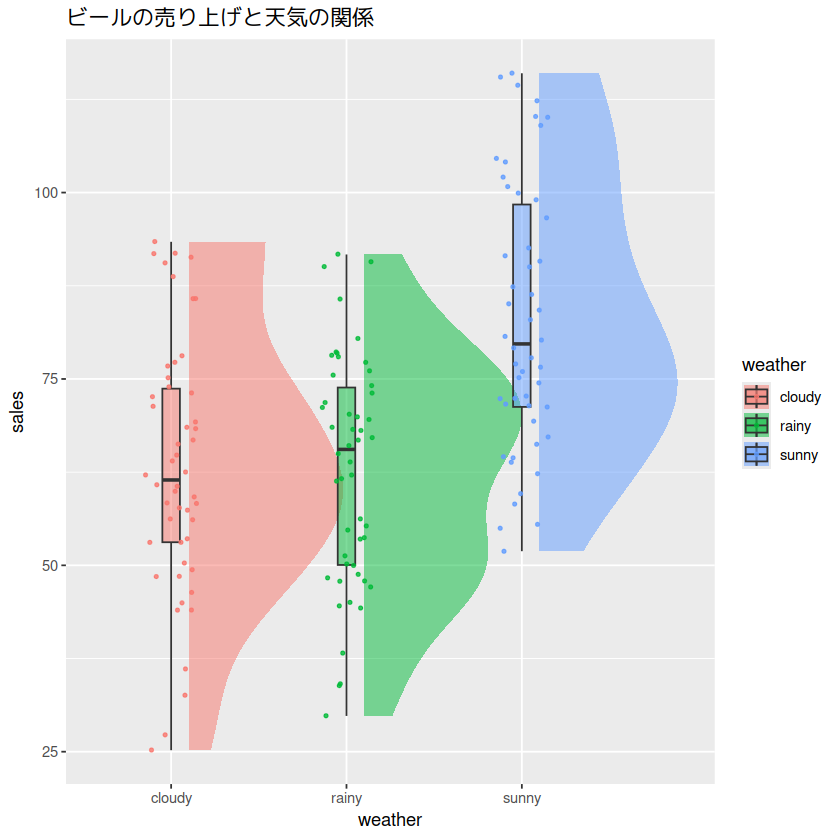

In [30]:
library(ggdist) # せっかくならraincloudプロットにしたい
ggplot(data = sales_weather, mapping = aes(x = weather, y = sales, fill = weather)) +
  stat_halfeye(point_color = NA, .width = 0, height = 0.6, position = position_nudge(x = 0.1), alpha = 0.5) +
  geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.5) +
  geom_point(aes(y = sales, color = weather), position = position_jitter(width = .15), size = .8, alpha = 0.8) +
  labs(title = "ビールの売り上げと天気の関係")


In [31]:
# 分散分析モデルの推定
anova_brms <- brm(
  formula = sales ~ weather,
  family = gaussian(),
  data = sales_weather,
  seed = 1,
  prior = c(
    set_prior("", class = "Intercept"),
    set_prior("", class = "sigma")
  )
)


Compiling Stan program...

Start sampling



In [32]:
# 推定結果
anova_brms


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: sales ~ weather 
   Data: sales_weather (Number of observations: 150) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       63.10      2.38    58.31    67.80 1.00     3285     2749
weatherrainy    -0.45      3.39    -7.10     6.17 1.00     3311     2764
weathersunny    19.91      3.35    13.10    26.53 1.00     3506     2648

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    16.92      0.99    15.07    18.96 1.00     3499     2847

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

Warning message:
“Method 'marginal_effects' is deprecated. Please use 'conditional_effects' instead.”


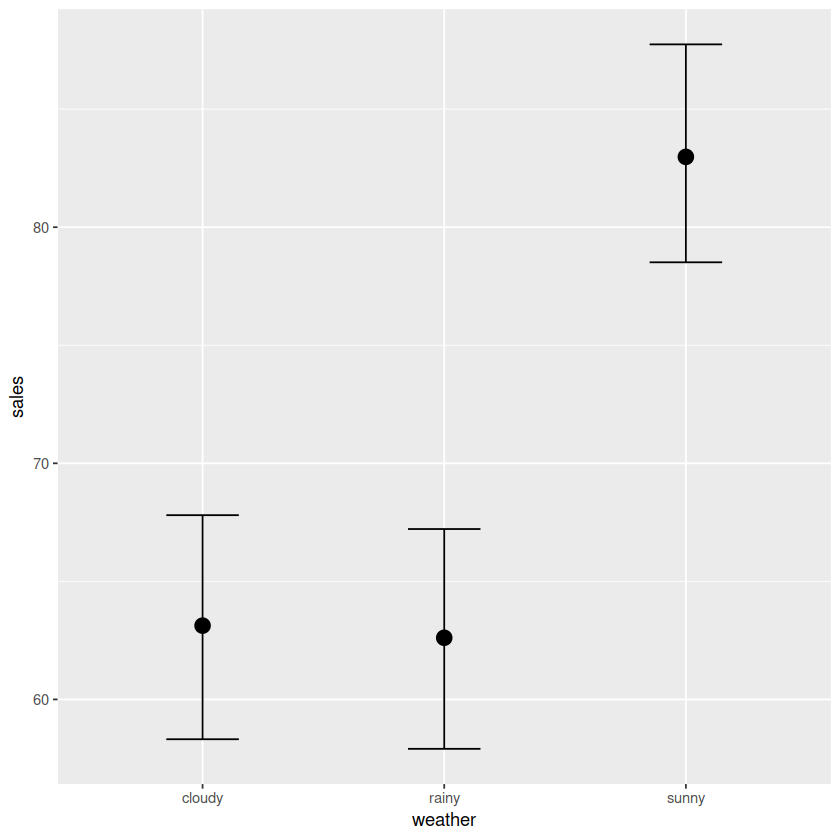

In [34]:
# 推定された天気別の平均売り上げグラフ
eff <- marginal_effects(anova_brms)
plot(eff, points = FALSE)


In [37]:
# brmsなしで分散分析

# デザイン行列の作成
formula_anova <- formula(sales ~ weather)
design_mat <- model.matrix(formula_anova, sales_weather)

data_list <- list(
  N = nrow(sales_weather),
  K = 3, # デザイン行列の列数
  Y = sales_weather$sales,
  X = design_mat
)


In [41]:
# stanでbrmsのモデルを実行
anova_stan <- stan(
  file = "3-4-1-lm-design-matrix.stan", # デザイン行列を使っているのでこれで分散分析も行える
  data = data_list,
  seed = 1
)


In [40]:
print(anova_stan, probs = c(0.025, 0.975))


Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd    2.5%   97.5% n_eff Rhat
b[1]    63.00    0.06 2.37   58.48   67.69  1712    1
b[2]    -0.23    0.08 3.28   -6.68    6.16  1892    1
b[3]    20.03    0.07 3.38   13.52   26.78  2050    1
sigma   16.90    0.02 0.99   15.09   18.90  2785    1
lp__  -495.68    0.03 1.42 -499.34 -493.92  1663    1

Samples were drawn using NUTS(diag_e) at Mon Jul 22 13:35:35 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
